### Requirements (to-do-list)
CHECK --> Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

CHECK --> Apply a distortion correction to raw images.

Use color transforms, gradients, etc., to create a thresholded binary image.

Apply a perspective transform to rectify binary image ("birds-eye view").

Detect lane pixels and fit to find the lane boundary.

Determine the curvature of the lane and vehicle position with respect to center.

Warp the detected lane boundaries back onto the original image.

Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
%matplotlib inline
#%matplotlib qt

### Utility function to print side-by-sides

In [2]:
def display_two(a,b,ta,tb):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(a,cmap='gray')
    ax1.set_title(ta, fontsize=30)
    ax2.imshow(b,cmap='gray')
    ax2.set_title(tb, fontsize=30)
def display_three(R,G,B,t1,t2,t3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
    f.tight_layout()
    ax1.imshow(R,cmap='gray')
    ax1.set_title(t1, fontsize=30)
    ax2.imshow(G,cmap='gray')
    ax2.set_title(t2, fontsize=30)
    ax3.imshow(B,cmap='gray')
    ax3.set_title(t3, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Loop through calibration images and find the chessboard corners on each image

In [3]:
images = glob.glob('./camera_cal/calibration*.jpg')

#coordinates of the board corners
objpoints = []
imgpoints = []
COLUMNS_TO_FIND = 6
objp = np.zeros((COLUMNS_TO_FIND*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:COLUMNS_TO_FIND].T.reshape(-1,2)

start = time.time()
for fname in images:
    
    img = mpimg.imread(fname)    
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret,corners = cv2.findChessboardCorners(gray, (9,COLUMNS_TO_FIND),None)
    
    if ret == True:    
        imgpoints.append(corners)
        objpoints.append(objp)

        #img = cv2.drawChessboardCorners(img, (9,5), corners, ret)
        
        #print("corners 0 0 ", corners[0][0])

        #print(len(corners),corners, ret)
fini = time.time()
print("It took {} seconds".format(str(fini-start)))

It took 3.085171937942505 seconds


### Below returns distortion coef, camera matrix, rotation vec, translation vec 

In [4]:
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None, None)

In [5]:
img = mpimg.imread('./camera_cal//calibration1.jpg')
undist = np.copy(img)
gray = cv2.cvtColor(undist,cv2.COLOR_RGB2GRAY)
undistorted = cv2.undistort(gray, mtx, dist, None, mtx)

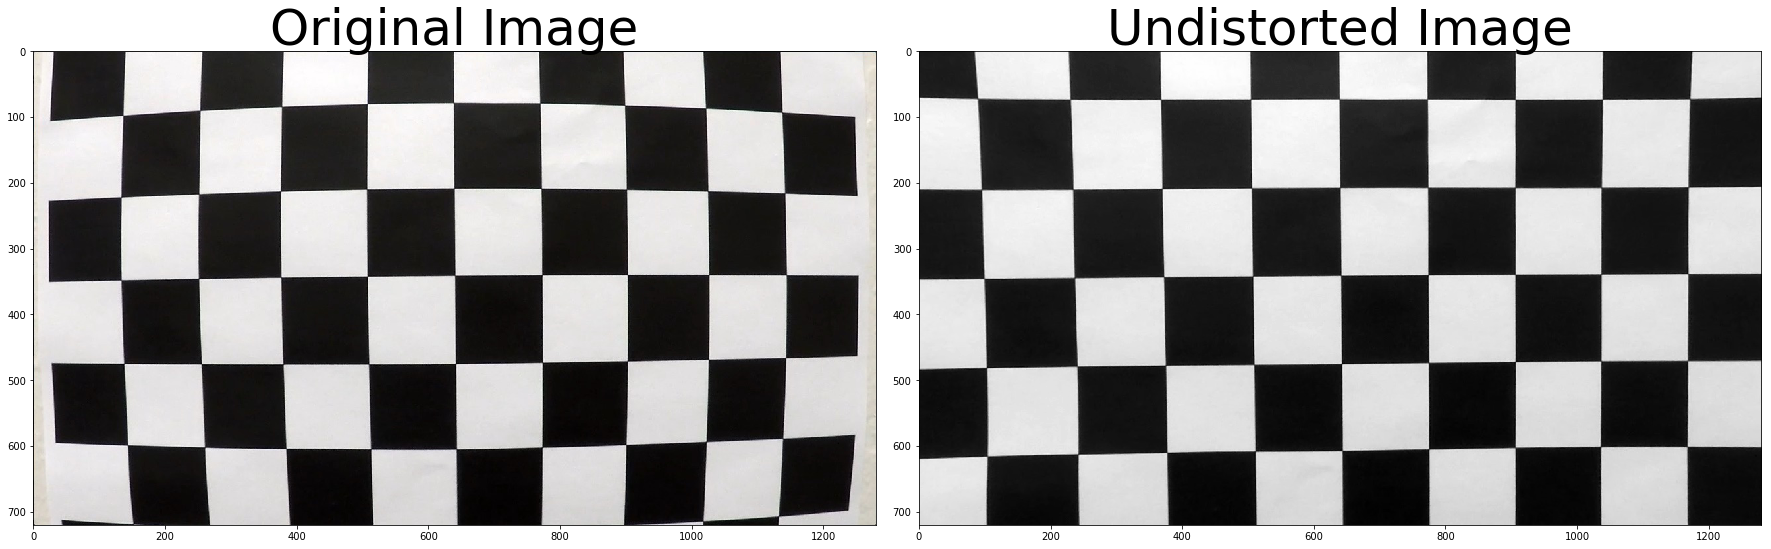

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted,cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Histogram on 33. Finding the Lanes

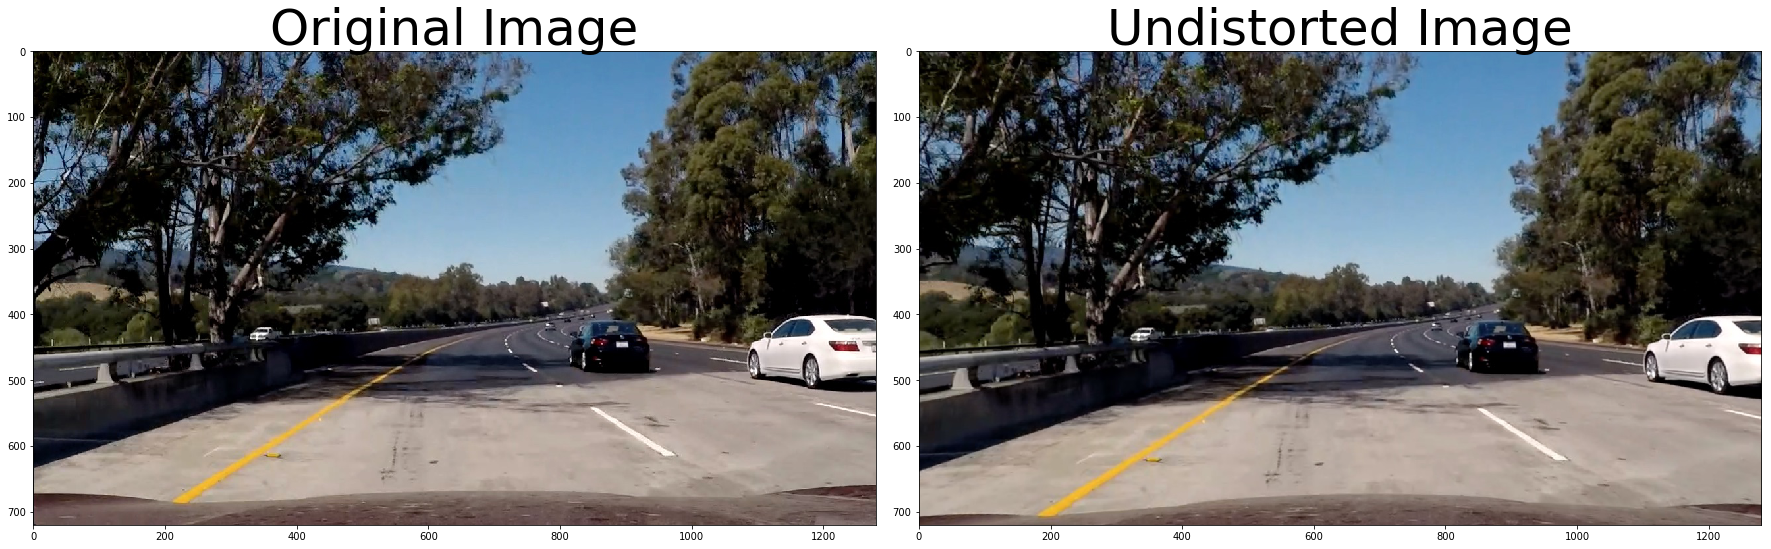

In [7]:
image_for_HLS = mpimg.imread('./test_images/test5.jpg')
#plt.imshow(image_for_HLS)
#gray = cv2.cvtColor(image_for_HLS,cv2.COLOR_RGB2GRAY)
undistorted = cv2.undistort(image_for_HLS, mtx, dist, None, mtx)

def printtwo(image_for_HLS, undistorted):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image_for_HLS)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted,cmap='gray')
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
printtwo(image_for_HLS, undistorted)

## Convert to HLS and get the S and do a thresholding on it

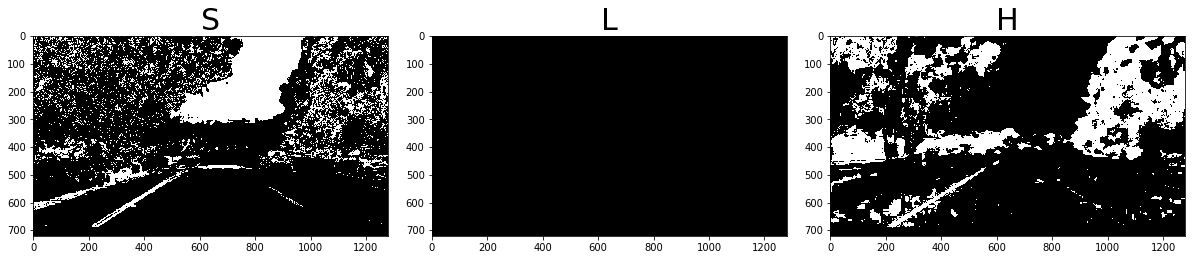

In [8]:
#image_for_HLS = mpimg.imread('./test_images/straight_lines1.jpg')
image_for_HLS = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(image_for_HLS, cv2.COLOR_RGB2HLS)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh_s = (90, 220)
S_binary = np.zeros_like(S)
S_binary[(S > thresh_s[0]) & (S <= thresh_s[1])] = 1

thresh_h = (15,50)
H_binary = np.zeros_like(H)
H_binary[(H > thresh_h[0]) & (H <= thresh_h[1])] = 1

thresh_l = (0,100)
L_binary = np.zeros_like(L)
L_binary[ (L > thresh_l[0]) & (L < thresh_l[1])]


display_three(S_binary,L_binary,H_binary,"S",'L','H')

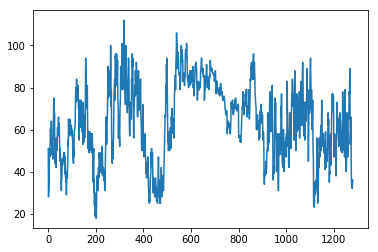

In [9]:
img = S_binary
histogram = np.sum(img[img.shape[0]//3:,:], axis=0)
plt.plot(histogram)

## Direction Threshold

In [10]:
def direction_threshold(img, sobel_kernel=15, thresh=(0, np.pi/3)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    imgcopy = np.copy(img)
    
    gray = cv2.cvtColor(imgcopy, cv2.COLOR_RGB2GRAY)    
    
    sobel = None
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobelx,sobely = np.absolute(sobelx), np.absolute(sobely)
    direction_of_gradient = np.arctan2( sobely, sobelx)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(direction_of_gradient)
    
    #make anything with the inputted thresholds 1
    sxbinary[(direction_of_gradient >= thresh_min) & (direction_of_gradient <= thresh_max)] = 1
    
    return sxbinary

### Sobel Function

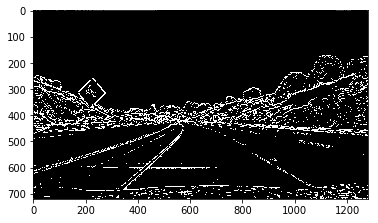

In [11]:
def abs_sobel_thresh(img, orient='x', thresh=(0, 255) ):
    
    imgcopy = np.copy(img)
    
    gray = cv2.cvtColor(imgcopy, cv2.COLOR_BGR2GRAY)
    
    assert orient== 'x' or orient=='y'
    
    sobel = None
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    #print(abs_sobel)
    #convert to 8-bit 0..255 image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    #numpy zeros_like --> Returns an array of zeros with the same shape and type as a given array.
    thresh_min = thresh[0]
    thresh_max = thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(scaled_sobel)
    
    #make anything with the inputted thresholds 1
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary
#call with 20.. 100
to_get_edges = cv2.imread('./test_images/test2.jpg')
got_edges = abs_sobel_thresh(to_get_edges, orient='y', thresh=(20,100) )


plt.imshow(got_edges,cmap='gray')
plt.plot(500,500,'r')

### From course Content !!!

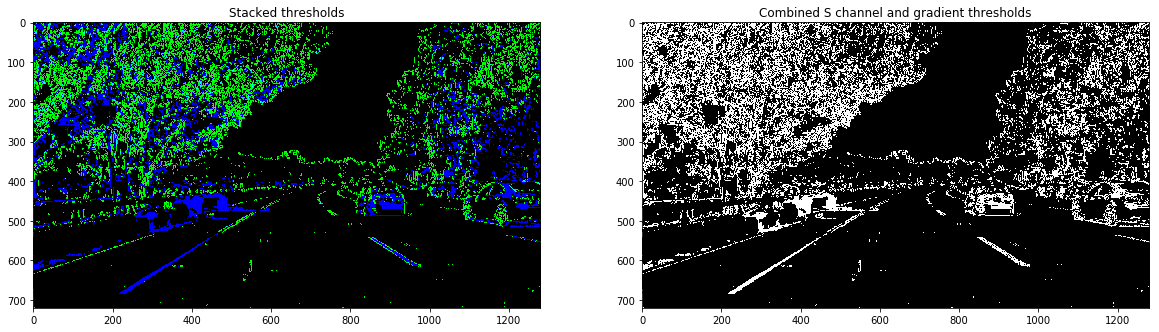

In [12]:
img  = mpimg.imread('./test_images/test5.jpg')
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 185
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')


In [30]:
def unwarp(img):
    
    img2 = np.copy(img)
    
    img_size = (img.shape[1], img.shape[0])
    
    corners = [[[595,450]],[[200,720]],[[1150,720]],[[695,450]]]
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([[250,0], [250,700],[960,700], [960,0]])        
    M = cv2.getPerspectiveTransform(src,dst)
    
    unwarped = cv2.warpPerspective(img2, M, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped

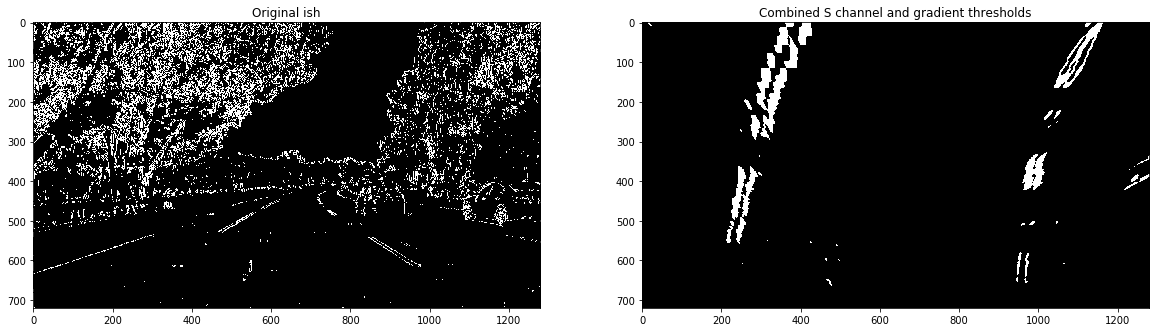

In [43]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    imgcopy = np.copy(img)
    
    gray = cv2.cvtColor(imgcopy, cv2.COLOR_RGB2GRAY)    
    
    sobel = None
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    sobelx,sobely = np.square(sobelx), np.square(sobely)
    abs_sobelxy = np.absolute(np.sqrt(sobelx + sobely) )
    
    #convert to 8-bit 0..255 image
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))

    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(scaled_sobel)
    
    #make anything with the inputted thresholds 1
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

#imgThr = sobel_x(imgRGB,9,80,220)
def abs_sobel_thresh(img, orient='x', thresh=(0, 255) ):
    
    imgcopy = np.copy(img)
    
    gray = cv2.cvtColor(imgcopy, cv2.COLOR_RGB2GRAY)
    
    assert orient== 'x' or orient=='y'    
    sobel = None
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    #without the np.absolute gets less noise
    abs_sobel = sobel
    #abs_sobel = np.absolute(sobel)
    
    #convert to 8-bit 0..255 image
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    #numpy zeros_like --> Returns an array of zeros with the same shape and type as a given array.
    thresh_min = thresh[0]
    thresh_max = thresh[1]    
    
    #new image array with zeros
    sxbinary = np.zeros_like(scaled_sobel)
    
    #make anything with the inputted thresholds 1
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sxbinary

img  = mpimg.imread('./test_images/test5.jpg')

img2 = abs_sobel_thresh(img, 'x',(20,100))
img3 = mag_thresh(img, 3, (50, 100))

unwarped = unwarp(img2)

unwarped = cv2.blur(unwarped,(5,5))

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original ish')
ax1.imshow(img2, cmap='gray')

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(unwarped, cmap='gray')

### Get a bird eye view of the lane, Perspective transform FIND THE POINTS, ORDER THEM ALL !!!!!

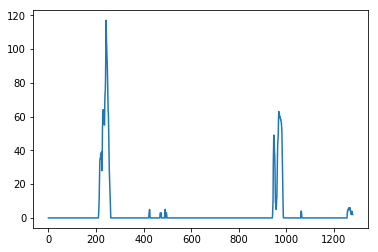

In [35]:
img = unwarped
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

(720, 0)

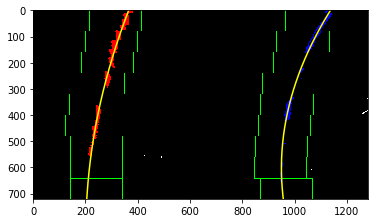

In [36]:
binary_warped = img

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#think of dstack as depth stack

In [37]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


(720, 0)

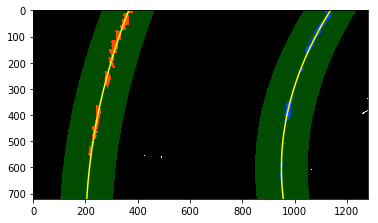

In [38]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

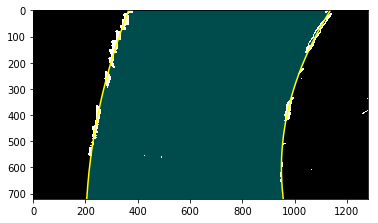

In [39]:
def draw_pw_lines(img,pts,color):
    # draw lines
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)

binary_warped = img
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])

right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
pts = np.hstack((left_line_window, right_line_window))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([pts]), (0,255, 255))

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)


col_L = (255,255,0)
col_R = (255,255,255)    
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

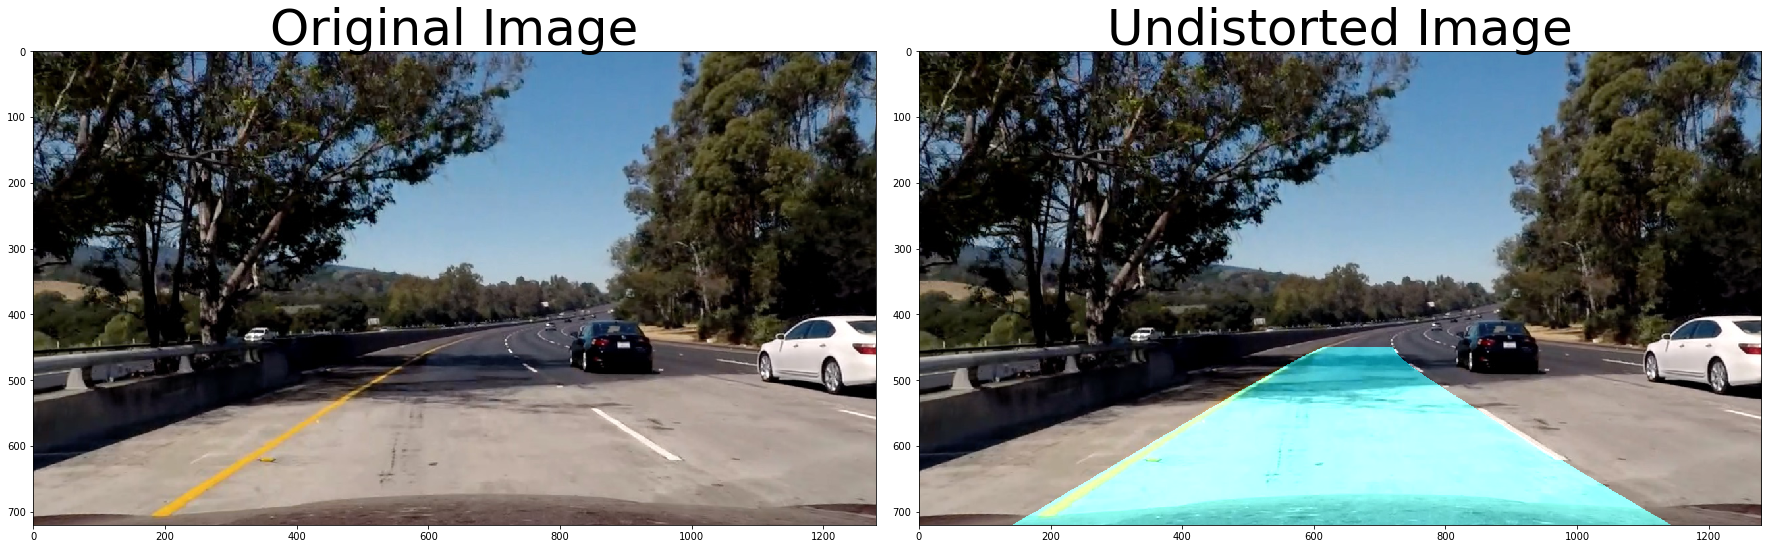

In [40]:
M_inverse = cv2.getPerspectiveTransform(dst, src)

newwarp = cv2.warpPerspective(window_img, M_inverse, (img.shape[1], img.shape[0])) 

result = cv2.addWeighted(undistorted, 1, newwarp, 0.5, 0)

printtwo(undistorted,result)


### The Inspiration

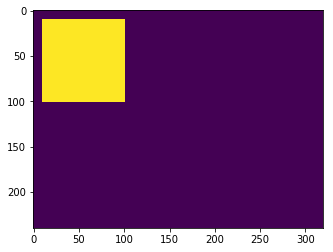

In [20]:
a3 = np.array( [[[10,10],[100,10],[100,100],[10,100]]], dtype=np.int32 )
im = np.zeros([240,320],dtype=np.uint8)
cv2.fillPoly( im, a3, 255 )

plt.imshow(im)
plt.show()

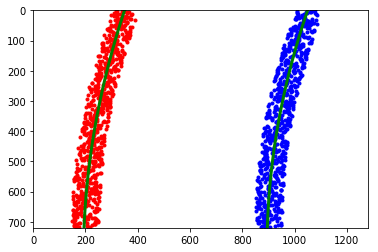

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images


In [25]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

2154.0903942 2005.13790029


In [28]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("left",left_curverad, 'm, ', "right",right_curverad, 'm')
# Example values: 632.1 m    626.2 m


left 705.128551876 m,  right 657.455280782 m
